# Проект для «Викишоп» с BERT

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#Загрузка-датасета" data-toc-modified-id="Загрузка-датасета-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Загрузка датасета</a></span></li><li><span><a href="#Исследование-и-подготовка-данных-к-обучению" data-toc-modified-id="Исследование-и-подготовка-данных-к-обучению-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Исследование и подготовка данных к обучению</a></span></li><li><span><a href="#Подготовка-данных-и-их-лемматизация" data-toc-modified-id="Подготовка-данных-и-их-лемматизация-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Подготовка данных и их лемматизация</a></span></li><li><span><a href="#Машинное-обучение" data-toc-modified-id="Машинное-обучение-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Машинное обучение</a></span><ul class="toc-item"><li><span><a href="#Классификация-с-помощью-TfidfVectorizer" data-toc-modified-id="Классификация-с-помощью-TfidfVectorizer-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Классификация с помощью TfidfVectorizer</a></span></li><li><span><a href="#Классификация-с-помощью-нейросети-BERT" data-toc-modified-id="Классификация-с-помощью-нейросети-BERT-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Классификация с помощью нейросети BERT</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

## Описание проекта
Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучим модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Построим модель со значением метрики качества *F1* не меньше 0.75. 

## Описание данных

-	`text` — содержит текст комментария

Целевой признак:
-    `toxic`

Данные находятся в файле: `toxic_comments.csv` 

**Импортирование библиотек**

In [1]:
%%capture

# Установка основных библиотек
%pip install -qq spacy
%pip install -qq scikit-learn catboost transformers==4.39.3 seaborn nltk ipywidgets tqdm
%pip install -qq --force-reinstall torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# Обновление scikit-learn (на случай, если уже установлен устаревший)
!pip install -q -U scikit-learn

# Загрузка модели spaCy
import spacy
spacy.cli.download("en_core_web_sm")

# Включение поддержки виджетов в Jupyter
!jupyter nbextension install --py widgetsnbextension --sys-prefix

In [2]:
import torch

print("CUDA доступен:", torch.cuda.is_available())
print("Версия CUDA:", torch.version.cuda)
print("Имя GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Нет CUDA")

CUDA доступен: True
Версия CUDA: 12.1
Имя GPU: NVIDIA GeForce GTX 1650


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import nltk
from tqdm.notebook import tqdm
from nltk.corpus import stopwords as nltk_stopwords

import re

from torch.utils.data import DataLoader, TensorDataset
from transformers import AdamW, DistilBertTokenizer, DistilBertForSequenceClassification

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import catboost as cb

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Пользователь\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Настройка выводов и константы**

In [6]:
# Настройки вывода графиков
plt.rcParams["axes.titlesize"] = 16  # Размер шрифта
plt.rcParams["axes.titleweight"] = "bold"  # Толщина шрифта

# Константы
RANDOM_STATE = 42
TEST_SIZE = 0.25
BATCH_SIZE = 32

## Загрузка датасета

In [7]:
import os
print(os.path.exists("C:\\Data-science\\ds_csv\\toxic_comments.csv"))

True


In [8]:
try:
    df = pd.read_csv("C:\\Data-science\\ds_csv\\toxic_comments.csv")
except:
    try:
        df = pd.read_csv('/datasets/toxic_comments.csv')
    except FileNotFoundError:
        print("Файл не найден. Проверьте путь.")
    except Exception as e:
        print(f"Ошибка при чтении файла: {e}")

## Исследование и подготовка данных к обучению

In [9]:
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


В датасете отсутствуют пропуски, но присутствует дублирующий столбец индексов, уберем его

In [10]:
df.drop('Unnamed: 0', axis= 1, inplace= True)
df.head(10)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [11]:
print('\033[1m','Количество дубликатов =', df.duplicated().sum(), '\033[0m')

 Количество дубликатов = 0 


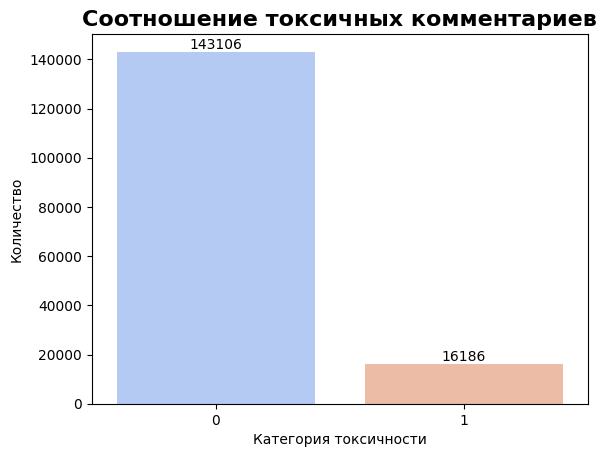

In [12]:
ax = sns.countplot(x='toxic', data=df, palette='coolwarm')
for container in ax.containers:
    ax.bar_label(container)

plt.xlabel("Категория токсичности")
plt.ylabel("Количество")
plt.title("Соотношение токсичных комментариев")
plt.show()

В датасете наблюдается сильный дисбаланс между токсичными и обычными комментариями.

**Вывод:**

- Был загружен датасет с комментариями (text) и меткой является ли этот комментарий токсичный (toxic);
- В датасете отсутствуют пропуски и дубликаты;
- Был удален дублирующий столбец индексов;
- В датасете был замечен сильный дисбаланс классов токсичности комментариев (не токсичных - 143106, токсичных - 16186).

## Подготовка данных и их лемматизация

In [13]:
def lemmatize_series(texts):
    lemmatized = []
    for doc in tqdm(nlp.pipe(texts, batch_size=BATCH_SIZE), total=len(texts)):
        lemmatized.append(" ".join([token.lemma_ for token in doc]))
    return lemmatized

In [14]:
def clear_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z'\s]", ' ', text)
    return " ".join(text.split())

In [15]:
tqdm.pandas()

# Очистка
df['clean_text'] = df['text'].progress_apply(clear_text)

# Лемматизация
df['lemm_text'] = lemmatize_series(df['clean_text'])

  0%|          | 0/159292 [00:00<?, ?it/s]

  0%|          | 0/159292 [00:00<?, ?it/s]

**Загрузка стопслов**

In [16]:
stopwords = list(nltk_stopwords.words('english'))

In [17]:
df.head(5)

,text,toxic,clean_text,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...,explanation why the edit make under my usernam...
1,D'aww! He matches this background colour I'm s...,0,d'aww he matches this background colour i'm se...,d'aww he match this background colour I be see...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i'm really not trying to edit war it's...,hey man I be really not try to edit war it be ...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can't make any real suggestions on impr...,more I can not make any real suggestion on imp...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...,you sir be my hero any chance you remember wha...


**Вывод**

Были подготовлены и лемматизированы данные с помощью библиотеки `spacy`, для дальнейшего обучения модели машинного обучения.

## Машинное обучение

### Классификация с помощью TfidfVectorizer

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(
    df['lemm_text'],
    df['toxic'],
    test_size=TEST_SIZE,
    stratify=df['toxic'],
    random_state=RANDOM_STATE
)

In [19]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(
        ngram_range=(1, 2),
        stop_words=stopwords, 
        min_df=3,
        max_df=0.9,
        strip_accents='unicode',
        use_idf=True,
        smooth_idf=True,
        sublinear_tf=True
    )),
    ('model', LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', max_iter=1000))
])

In [20]:
param_grid = [
    {
        'model': [LogisticRegression(random_state=RANDOM_STATE,
                                     solver='liblinear',
                                     max_iter=1000)]
    },
    {
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'model__max_depth': [3, 5],
        'model__min_samples_split': [2],
        'model__min_samples_leaf': [2],
    },
    {
        'model': [
            cb.CatBoostClassifier(
                random_state=RANDOM_STATE,
                verbose=100,
                iterations=1000,
                loss_function='Logloss',
                custom_metric='F1'
            )
        ]
    }
]

In [21]:
# Измерение времени обучения
start_time = time.time()

clf_ntlk = GridSearchCV(
    pipe,
    param_grid=param_grid, 
    scoring='f1', 
    cv=3, 
    verbose=True, 
    n_jobs=1
)

clf_ntlk.fit(X_train, y_train)
training_time_clf = time.time() - start_time

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Learning rate set to 0.066793
0:	learn: 0.6238119	total: 1.07s	remaining: 17m 45s
100:	learn: 0.1759196	total: 1m 46s	remaining: 15m 49s
200:	learn: 0.1530291	total: 3m 33s	remaining: 14m 7s
300:	learn: 0.1390871	total: 5m 19s	remaining: 12m 21s
400:	learn: 0.1297435	total: 7m 5s	remaining: 10m 35s
500:	learn: 0.1230674	total: 8m 50s	remaining: 8m 48s
600:	learn: 0.1177862	total: 10m 36s	remaining: 7m 2s
700:	learn: 0.1132347	total: 12m 22s	remaining: 5m 16s
800:	learn: 0.1092026	total: 14m 7s	remaining: 3m 30s
900:	learn: 0.1054997	total: 15m 53s	remaining: 1m 44s
999:	learn: 0.1023066	total: 17m 37s	remaining: 0us
Learning rate set to 0.066793
0:	learn: 0.6243488	total: 849ms	remaining: 14m 8s
100:	learn: 0.1768144	total: 1m 24s	remaining: 12m 34s
200:	learn: 0.1539520	total: 2m 48s	remaining: 11m 11s
300:	learn: 0.1401189	total: 4m 12s	remaining: 9m 46s
400:	learn: 0.1306427	total: 5m 35s	remaining: 8m 21s
500:	learn: 0.123

In [34]:
print(training_time_clf / 3600)

1.1732465671830707


In [23]:
print(f"Лучший результат F1_score: {clf_ntlk.best_score_:.3f}")
print("Лучшие параметры:", clf_ntlk.best_params_)

Лучший результат F1_score: 0.756
Лучшие параметры: {'model': <catboost.core.CatBoostClassifier object at 0x00000151BE1E85E0>}


In [24]:
# Оценка на валидационной выборке
best_model = clf_ntlk.best_estimator_
y_pred = best_model.predict(X_valid)
f1 = f1_score(y_valid, y_pred)
print(f"✅ F1_score на валидационных данных: {f1:.3f}")

✅ F1_score на валидационных данных: 0.761


**Вывод**

- Были обучены 3 модели (`LogisticRegression`, `DecisionTreeClassifier`, `CatBoostClassifier`) с подбором гиперпараметров;
- Лучшей моделью оказалась `CatBoostClassifier` с метрикой `f1_score = 0.756` на тренировочной выборке и `f1_score = 0.761` на валидационной;
- Время обучения модели - 1.17 часа;
- Полученное значение `f1_score` на валидационной выборке, удовлетворяет требованию - быть не менее 0.75.

### Классификация с помощью нейросети BERT

In [25]:
# Разделение изначального датасета на train и val
train_df, val_df = train_test_split(
    df, test_size=TEST_SIZE, stratify=df['toxic'], random_state=RANDOM_STATE
)

In [26]:
# Инициализация токенизатора
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Проверка на работу cuda ядер
print("Using device:", device)

print(torch.cuda.is_available())
print(torch.version.cuda)

Using device: cuda
True
12.1


**Инициализация модели DistilBertForSequenceClassification**

In [27]:
def model_init():
    return DistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-uncased',
        num_labels=2
    )

In [28]:
# Определение параметров
BATCH_SIZE = BATCH_SIZE
RANDOM_STATE = RANDOM_STATE
MAX_LENGTH = 128
NUM_EPOCHS = 1

In [29]:
# 🔹 Функция токенизации и кодирования текстов
def tokenize_and_encode(tokenizer, texts, labels, max_length=MAX_LENGTH):
    input_ids = []
    attention_masks = []

    for text in texts:
        # Токенизация текста и преобразование в тензоры
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,      # Добавляем спец. токены ([CLS], [SEP])
            max_length=max_length,        # Максимальная длина текста
            padding='max_length',         # Дополнение до max_length
            truncation=True,              # Обрезка слишком длинных текстов
            return_attention_mask=True,   # Маска внимания
            return_tensors='pt'           # Вывод в формате PyTorch Tensor
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    # Объединяем тензоры по размерности 0 (батчи)
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels.values, dtype=torch.long)

    return input_ids, attention_masks, labels

# 🔹 Функция обучения модели на одном фолде
def train_model(model, dataloader, optimizer, device, num_epochs):
    model.train()  # Переводим модель в режим обучения
    loss_fn = torch.nn.CrossEntropyLoss()  # Используем функцию потерь для классификации

    for epoch in range(num_epochs):
        total_loss = 0  # Суммарный лосс за эпоху

        for batch in tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            # Загружаем батч на GPU/CPU
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            optimizer.zero_grad()  # Обнуляем градиенты
            outputs = model(input_ids, attention_mask=attention_mask)  # Прямой проход
            logits = outputs.logits  # Предсказания

            loss = loss_fn(logits, labels)  # Вычисляем лосс
            loss.backward()  # Обратное распространение ошибки
            optimizer.step()  # Обновляем веса

            total_loss += loss.item()  # Сохраняем значение лосса

        avg_loss = total_loss / len(dataloader)
        print(f"🟩 Epoch {epoch + 1} — Average Loss: {avg_loss:.4f}")

# 🔹 Основная функция: K-Fold кросс-валидация + финальное тестирование
def run_kfold_cv(train_df, val_df, tokenizer, device, model_init,
                 k_folds=5, batch_size=16, num_epochs=3, max_length=128):

    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
    train_f1_scores = []

    # ✅ Предобработка валидационного датасета (один раз)
    val_input_ids, val_attention_masks, val_labels = tokenize_and_encode(tokenizer, val_df['text'], val_df['toxic'], max_length)
    val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    for fold, (train_idx, _) in enumerate(skf.split(train_df['text'], train_df['toxic'])):
        print(f'\n====================== Fold {fold + 1}/{k_folds} ======================')

        # 🔄 Получаем подмножество данных для текущего фолда
        X_train = train_df.iloc[train_idx]['text']
        y_train = train_df.iloc[train_idx]['toxic']

        # Токенизация тренировочной части
        train_input_ids, train_attention_masks, train_labels = tokenize_and_encode(tokenizer, X_train, y_train, max_length)
        train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        # 🎯 Инициализация новой модели и оптимизатора
        model = model_init().to(device)
        optimizer = AdamW(model.parameters(), lr=2e-5)

        # 🔧 Обучаем модель
        train_model(model, train_loader, optimizer, device, num_epochs)

        # 📊 F1 на обучающей части
        model.eval()
        all_train_preds = []
        all_train_labels = []

        with torch.no_grad():
            for batch in train_loader:
                input_ids, attention_mask, labels_batch = [b.to(device) for b in batch]
                outputs = model(input_ids, attention_mask=attention_mask)
                preds = torch.argmax(outputs.logits, dim=1)

                all_train_preds.extend(preds.cpu().numpy())
                all_train_labels.extend(labels_batch.cpu().numpy())

        train_fold_f1 = f1_score(all_train_labels, all_train_preds)
        print(f'📌 Fold {fold + 1} F1-score (train): {train_fold_f1:.4f}')
        train_f1_scores.append(train_fold_f1)

    # 🧪 Финальная валидация
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels_batch = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)

            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels_batch.cpu().numpy())

    val_f1 = f1_score(val_labels, val_preds)

    # 📈 Вывод результатов
    print(f'\n✅ Средний F1-score по {k_folds} фолдам (train): {np.mean(train_f1_scores):.4f}')
    print(f'✅ F1-score на валидационной выборке: {val_f1:.4f}')

    # 💾 Сохраняем обученную модель и токенизатор
    final_model_path = "final_model"
    os.makedirs(final_model_path, exist_ok=True)
    model.save_pretrained(final_model_path)
    tokenizer.save_pretrained(final_model_path)
    print(f'\n💾 Модель и токенизатор сохранены в: {final_model_path}')

    return train_f1_scores, val_f1

In [31]:
# Измерение времени обучения
start_time = time.time()

f1_train_list, f1_val = run_kfold_cv(
    train_df,
    val_df,
    tokenizer,
    device,
    model_init=model_init,  
    k_folds=3,
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    max_length=MAX_LENGTH
)

training_time_bert = time.time() - start_time


====================== Fold 1/3 ======================


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1:   0%|          | 0/2489 [00:00<?, ?it/s]

🟩 Epoch 1 — Average Loss: 0.0997
📌 Fold 1 F1-score (train): 0.8754

====================== Fold 2/3 ======================


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1:   0%|          | 0/2489 [00:00<?, ?it/s]

🟩 Epoch 1 — Average Loss: 0.1036
📌 Fold 2 F1-score (train): 0.8948

====================== Fold 3/3 ======================


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1:   0%|          | 0/2489 [00:00<?, ?it/s]

🟩 Epoch 1 — Average Loss: 0.1008
📌 Fold 3 F1-score (train): 0.8784

✅ Средний F1-score по 3 фолдам (train): 0.8829
✅ F1-score на валидационной выборке: 0.8147

💾 Модель и токенизатор сохранены в: final_model


In [33]:
print(training_time_bert / 3600)

3.6676002035538358


**Вывод**

- Модель DistilBert справилась с классификацией лучше, ее метрика на тренировочной выборке `f1_score=0.8829`, а на валидационной `f1_score=0.8147`.
- Время обучения модели 3.67 часа.

## Общий вывод

1. Загружены данные с комментариями магазина «Викишоп».
2. Был проведен анализ данных в ходе которого не было обнаружено пропусков и дубликатов.
3. Удален дублирующий столбец `Unnamed: 0` содержащий индексы.
4. Были подготовлены и лемматизированы данные с помощью библиотеки `spacy`, для дальнейшего обучения модели машинного обучения.
5. Были обучены 3 модели (`LogisticRegression`, `DecisionTreeClassifier`, `CatBoostClassifier`) с подбором гиперпараметров:
    - Лучшей моделью оказалась `CatBoostClassifier` с метрикой `f1_score = 0.756` на тренировочной выборке и `f1_score = 0.761` на валидационной;
    - Время обучения модели - 1.17 часа;
    - Полученное значение `f1_score` на валидационной выборке, удовлетворяет требованию - быть не менее 0.75.
6. Была обучена 1 модель с нейросетью DistilBert:
    - Метрика на тренировочной выборке `f1_score=0.8829`, а на валидационной `f1_score=0.8147`;
    - Время обучения модели 3.67 часа;
    - Полученное значение `f1_score` на валидационной выборке, удовлетворяет требованию - быть не менее 0.75.

Использование моделей с нейросетями помогает улучшить качество модели, но требует больше временных затрат (примерно в 3 раза), а также ресурсов компьютера (без cuda ядер обучение длилось бы в разы дольше).